In [1]:
# import Modules
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
# import stl file
stl_mesh = mesh.Mesh.from_file('3DBenchy.stl')
print("File loaded in as faces and vertices")

exception (False, "b'\\xd7\\xd3@\\x00\\x00\\xa0\\xbf\\xdfo\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x0b\\xd5\\xc1&*\\xaf\\xa0=\\xa0\\x1a\\xd3@\\xbe\\x9f\\x9a\\xbf\\xc3\\xf5\\x9aa)\\\\\\xd3@\\xa4p\\x9d\\xbfj\\xbc\\x9bam\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x86\\xaa\\xa9\\xa6*\\xaf\\xa0=)\\\\\\xd3@\\xa4p\\x9d\\xbfj\\xbc\\x9ba\\x81\\x95\\xd3@d;\\x9f\\xbf\\x1f\\x85\\x9cam\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x1b\\x82\\x80%*\\xaf\\xa0=m\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x81\\x95\\xd3@d;\\x9f\\xbf\\x1f\\x85\\x9ca' should start with b'facet normal'")
File loaded in as faces and vertices


In [3]:
# slice STL model up on all ZZ layers

#check if code works for all faces in the stl
zz = np.linspace(0,30,150) # z slices

# save all points
Set_1 = np.zeros([3,0])
Set_2 = np.zeros([3,0])

# save faces that dont would through error
Bad_Faces = np.array([])

l = len(stl_mesh.vectors[:])
#l = 50000*2
for face in range(l):
    # check if face is actually a line (bad stl file)
    v1 = stl_mesh.vectors[face][0,:] - stl_mesh.vectors[face][1,:]
    v2 = stl_mesh.vectors[face][1,:] - stl_mesh.vectors[face][2,:] 
    v3 = stl_mesh.vectors[face][2,:] - stl_mesh.vectors[face][0,:]
    # check that face intercept z point
    z_lim = np.array([stl_mesh.vectors[face][:,2].min(),stl_mesh.vectors[face][:,2].max()])
    inter = (z_lim[0]-zz)*(z_lim[1]-zz) < 0
    
    if np.any(np.all(v1==0) or np.all(v2==0) or np.all(v3==0) or np.all(inter)):
        Bad_Faces = np.append(Bad_Faces,face) # for debugging
        # just compute random task
    else:
        
        # code used to find slice lines
        t = np.zeros([3]) # initilaize line parameter

        ## solve for all z intercepts
        idx = np.where((zz>z_lim[0]) & (zz<z_lim[1]))[0]

        # solve line intercept parameter value
        t = np.zeros([3,len(idx)])

        t[0,:] = np.transpose((zz[idx]-stl_mesh.vectors[face][0,2])/(stl_mesh.vectors[face][1,2]-stl_mesh.vectors[face][0,2]))
        t[1,:] = np.transpose((zz[idx]-stl_mesh.vectors[face][1,2])/(stl_mesh.vectors[face][2,2]-stl_mesh.vectors[face][1,2]))
        t[2,:] = np.transpose((zz[idx]-stl_mesh.vectors[face][2,2])/(stl_mesh.vectors[face][0,2]-stl_mesh.vectors[face][2,2]))

        II0 = np.array((stl_mesh.vectors[face][1,:]-stl_mesh.vectors[face][0,:]).reshape(-1,1)*t[0,:] + stl_mesh.vectors[face][0,:].reshape(-1,1))
        II1 = np.array((stl_mesh.vectors[face][2,:]-stl_mesh.vectors[face][1,:]).reshape(-1,1)*t[1,:] + stl_mesh.vectors[face][1,:].reshape(-1,1))
        II2 = np.array((stl_mesh.vectors[face][0,:]-stl_mesh.vectors[face][2,:]).reshape(-1,1)*t[2,:] + stl_mesh.vectors[face][2,:].reshape(-1,1))

        # remove points outside of bounds
        idx0 = ((II0[0,:]<stl_mesh.vectors[face][[0,1],0].min()) + (II0[0,:]>stl_mesh.vectors[face][[0,1],0].max()) 
            + (II0[1,:]<stl_mesh.vectors[face][[0,1],1].min()) + (II0[1,:]>stl_mesh.vectors[face][[0,1],1].max())
            + (II0[2,:]<stl_mesh.vectors[face][[0,1],2].min()) + (II0[2,:]>stl_mesh.vectors[face][[0,1],2].max()))
        idx1 = ((II1[0,:]<stl_mesh.vectors[face][[1,2],0].min()) + (II1[0,:]>stl_mesh.vectors[face][[1,2],0].max()) 
            + (II1[1,:]<stl_mesh.vectors[face][[1,2],1].min()) + (II1[1,:]>stl_mesh.vectors[face][[1,2],1].max())
            + (II1[2,:]<stl_mesh.vectors[face][[1,2],2].min()) + (II1[2,:]>stl_mesh.vectors[face][[1,2],2].max()))
        idx2 = ((II2[0,:]<stl_mesh.vectors[face][[0,2],0].min()) + (II2[0,:]>stl_mesh.vectors[face][[0,2],0].max()) 
            + (II2[1,:]<stl_mesh.vectors[face][[0,2],1].min()) + (II2[1,:]>stl_mesh.vectors[face][[0,2],1].max())
            + (II2[2,:]<stl_mesh.vectors[face][[0,2],2].min()) + (II2[2,:]>stl_mesh.vectors[face][[0,2],2].max()))
        
        # save points for every intercept for every z level...
        II0[:,idx0] = 0
        II1[:,idx1] = 0
        II2[:,idx2] = 0

        # combine points into pairs of points that can be stored easily
        # find the ONE line that has all points within bonds. This is the base line
        # the secondary points are the sum of the other two points becuase index above 
        # sets outof bounds points to zero
        if(sum(idx0)==0):
                P1 = II0
                P2 = II1 + II2
        elif(sum(idx1)==0):
                P1 = II1
                P2 = II0 + II2
        else:
                P1 = II2
                P2 = II0 + II1
        
        Set_1 = np.append(Set_1,P1,axis=1)
        Set_2 = np.append(Set_2,P2,axis=1)
       
print("Num of Bad Faces: ",len(Bad_Faces)," Total Num of Faces: ",len(stl_mesh.vectors[:]))

C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/1139294770.py:40: RuntimeWarning: divide by zero encountered in true_divide
  t[2,:] = np.transpose((zz[idx]-stl_mesh.vectors[face][2,2])/(stl_mesh.vectors[face][0,2]-stl_mesh.vectors[face][2,2]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/1139294770.py:44: RuntimeWarning: invalid value encountered in multiply
  II2 = np.array((stl_mesh.vectors[face][0,:]-stl_mesh.vectors[face][2,:]).reshape(-1,1)*t[2,:] + stl_mesh.vectors[face][2,:].reshape(-1,1))
C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/1139294770.py:38: RuntimeWarning: divide by zero encountered in true_divide
  t[0,:] = np.transpose((zz[idx]-stl_mesh.vectors[face][0,2])/(stl_mesh.vectors[face][1,2]-stl_mesh.vectors[face][0,2]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/1139294770.py:42: RuntimeWarning: invalid value encountered in multiply
  II0 = np.array((stl_mesh.vectors[face][1,:]-stl_mesh.vectors[face][0,:]).reshape(-1,1)*t[0,:] + stl_mesh.vectors[face][

Num of Bad Faces:  552  Total Num of Faces:  225706


Z height is:  20.13422818791946
shape of Set 1: (3, 201613)
shape of Set 2: (3, 201613)


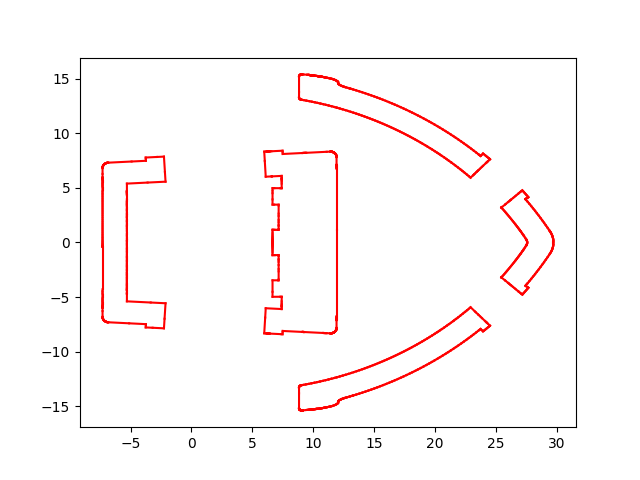

In [4]:
# plot slice of object at zz[ind]
ind = 100
print("Z height is: ",zz[ind])
print("shape of Set 1:",Set_1.shape)
print("shape of Set 2:",Set_2.shape)

idx = Set_1[2,:] == zz[ind] # find all points on that zz height
p1 = Set_1[0:2,idx] # first set of points [x1,y1]
p2 = Set_2[0:2,idx] # 2nd set of points [x2,y2]

for i in range(sum(idx)):
    plt.plot([p1[0,i],p2[0,i]],[p1[1,i],p2[1,i]],"r")
plt.show()

In [21]:
# Create rays that will percise layer
theta = 90*np.pi/180 # angle of lines
space = 1.5 # spacing between lines
num = 5 # number of lines

# iterction math: https://www.cuemath.com/geometry/intersection-of-two-lines/
rays = np.zeros([3,num]) # empty matrix with a,b and c values ax+by+c=0
if (theta == 0): #horizontal lines
    print("horizontal")
    rays[0,:] = 0
    rays[1,:] = 1
    rays[2,:] = np.arange(0, space*num,space) - num*space/2 + space/2
elif (theta == np.pi/2): # vertical lines
    print("Vertical")
    rays[0,:] = 1
    rays[1,:] = 0
    rays[2,:] = np.arange(0, space*num,space) - num*space/2 + space/2
else:
    print("angle")
    rays[0,:] = -np.tan(theta)
    rays[1,:] = 1
    rays[2,:] = (np.arange(0, space*num,space) - num*space/2 + space/2)/np.abs(np.cos(theta))

Vertical


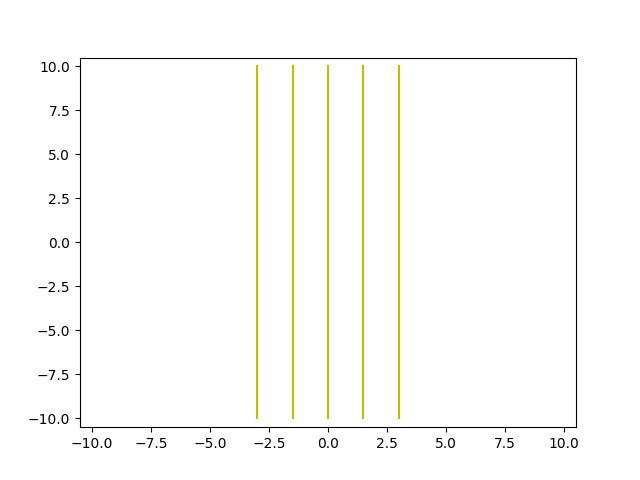

In [22]:
# plotting 
def Plot_Rays(rays,xlim,ylim):
    # takes ray parameters, x limit, and
    # y limit and plots the lines
    y = np.zeros([2,len(rays[0,:])])
    x = np.zeros([2,len(rays[0,:])])
    if (np.all(rays[1,:]==0)): # horizontal lines
        # generate lines
        y[0,:] += ylim[0]
        y[1,:] += ylim[1]
        x[0,:] = -(rays[1,:]*y[0,:]+rays[2,:])/rays[0,:]
        x[1,:] = -(rays[1,:]*y[1,:]+rays[2,:])/rays[0,:]
    else:
        # generate lines
        x[0,:] += xlim[0]
        x[1,:] += xlim[1]
        y[0,:] = -(rays[0,:]*x[0,:]+rays[2,:])/rays[1,:]
        y[1,:] = -(rays[0,:]*x[1,:]+rays[2,:])/rays[1,:]
    # plot lines
    plt.plot(x,y,'y')
    plt.xlim(xlim[0]*1.05,xlim[1]*1.05)
    plt.ylim(ylim[0]*1.05,ylim[1]*1.05)
    plt.show()

# plot rays generated in cell above

xlim = np.array([-10,10])
ylim = np.array([-10,10])

plt.close()
Plot_Rays(rays,xlim,ylim) 
plt.plot(0,0,"*")


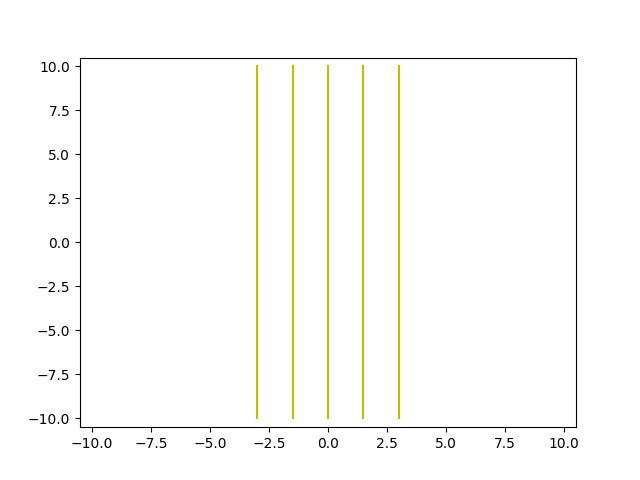

In [42]:
# plotting 
def Plot_Rays(rays,xlim,ylim): # New Version
    # takes ray parameters, x limit, and
    # y limit and plots the lines
    y = np.zeros([2,len(rays[0,:])])
    x = np.zeros([2,len(rays[0,:])])

    idx_vert = rays[1,:] == 0 # rays with vertical slope
    idx_line = idx_vert == 0 # all other rays

    # generate lines
    y[0,idx_vert] += ylim[0]
    y[1,idx_vert] += ylim[1]
    x[0,idx_vert] = -(rays[1,idx_vert]*y[0,idx_vert]+rays[2,idx_vert])/rays[0,idx_vert]
    x[1,idx_vert] = -(rays[1,idx_vert]*y[1,idx_vert]+rays[2,idx_vert])/rays[0,idx_vert]

    # generate lines
    x[0,idx_line] += xlim[0]
    x[1,idx_line] += xlim[1]
    y[0,idx_line] = -(rays[0,idx_line]*x[0,idx_line]+rays[2,idx_line])/rays[1,idx_line]
    y[1,idx_line] = -(rays[0,idx_line]*x[1,idx_line]+rays[2,idx_line])/rays[1,idx_line]

    # plot lines
    plt.plot(x,y,'y')
    plt.xlim(xlim[0]*1.05,xlim[1]*1.05)
    plt.ylim(ylim[0]*1.05,ylim[1]*1.05)

# plot rays generated in cell above

xlim = np.array([-10,10])
ylim = np.array([-10,10])

plt.close()
Plot_Rays(rays,xlim,ylim) 

In [43]:
# parameterize slice points into lines
def Line_Generator(P1,P2):
    # takes to points P = [[x],[y]]
    # returns vector of a,b,c for line
    # ax+by+c=0
    a =-(P2[1] - P1[1])
    b = P2[0] - P1[0]
    c = -P1[0]*a - P1[1]*b
    return np.array([a,b,c])

slices = Line_Generator(p1,p2)

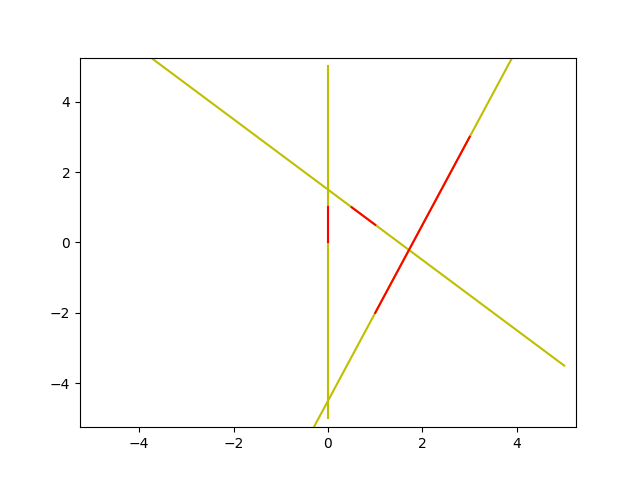

In [44]:
# test line generations
P1 = np.array([[0,.5,1],[0,1,-2]])
P2 = np.array([[0,1,3],[1,0.5,3]])

test = Line_Generator(P1,P2)
xlim = np.array([-5,5])
ylim = np.array([-5,5])

plt.close()
Plot_Rays(test,xlim,ylim) 
def Plot_slice(P1,P2):
    x1 = P1[0]
    x2 = P2[0]
    y1 = P1[1]
    y2 = P2[1]
    plt.plot([x1,x2],[y1,y2],'r')

Plot_slice(P1,P2)

In [54]:
# find intercetion points between rays and slice
def Line_Intersection(P1,P2):
    # takes P = [[a],[b],[c]] where ax+by+C=0
    # returns points of intersection [x,y]
    # for all possible line combose
    x = (np.outer(P1[1],P2[2])-np.outer(P1[2],P2[1]))/(np.outer(P1[0],P2[1])-np.outer(P1[1],P2[0]))
    y = (np.outer(P1[2],P2[0])-np.outer(P1[0],P2[2]))/(np.outer(P1[0],P2[1])-np.outer(P1[1],P2[0]))
    return [x,y]

Xp,Yp = Line_Intersection(rays,slices)
#xpp = Xp
#ypp = Yp
print(Xp)

[[ 3.   3.   3.  ...  nan  3.   3. ]
 [ 1.5  1.5  1.5 ...  nan  1.5  1.5]
 [-0.   0.  -0.  ...  nan -0.   0. ]
 [-1.5 -1.5 -1.5 ...  nan -1.5 -1.5]
 [-3.  -3.  -3.  ...  nan -3.  -3. ]]


C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/403358198.py:6: RuntimeWarning: invalid value encountered in true_divide
  x = (np.outer(P1[1],P2[2])-np.outer(P1[2],P2[1]))/(np.outer(P1[0],P2[1])-np.outer(P1[1],P2[0]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_18784/403358198.py:7: RuntimeWarning: divide by zero encountered in true_divide
  y = (np.outer(P1[2],P2[0])-np.outer(P1[0],P2[2]))/(np.outer(P1[0],P2[1])-np.outer(P1[1],P2[0]))


In [59]:
# filter out data points that dont lie inbtween p1 p2
def Out_Of_Bound(x,y,P1,P2):
    # takes points of intersection of lines and
    # points of lines. replaces all points not 
    # inbetween P1, P2 returns x,y
    xmax = np.max([P1[0],P2[0]],axis=0)
    xmin = np.min([P1[0],P2[0]],axis=0)
    ymax = np.max([P1[1],P2[1]],axis=0)
    ymin = np.min([P1[1],P2[1]],axis=0)
    idx = ((x<=xmin) | (x>=xmax)) | ((y<=ymin) | (y>=ymax))
    #idx = ((x>xmin) | (x<xmax)) | ((y>ymin) | (y<ymax))
    #idx = ((x>=xmin) | (x<=xmax)) | ((y>=ymin) | (y<=ymax))
    x[idx] = np.NaN
    y[idx] = np.NaN
    return x,y

xpp,ypp = Out_Of_Bound(Xp,Yp,p1,p2) 
print(xpp)
print(ypp)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


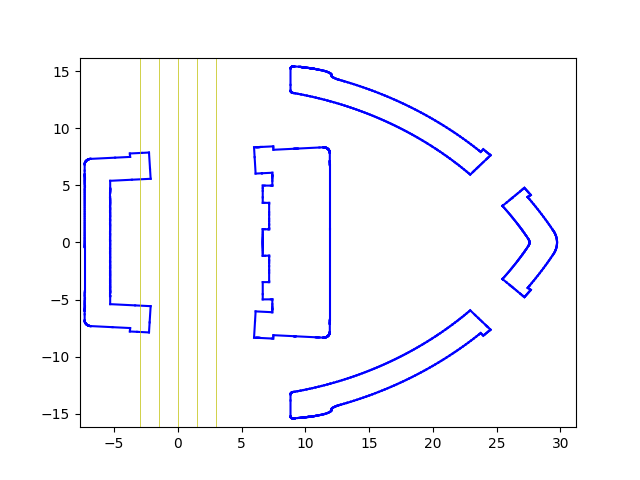

In [52]:
# plot results
plt.close()

for i in range(sum(idx)): # plot outline
    plt.plot([p1[0,i],p2[0,i]],[p1[1,i],p2[1,i]],"b")

# Plot rays
if (theta==90*np.pi/180): # for vertical lines
    Y1line = np.ones(num)*-50
    X1line = (rays[1,:]*Y1line-rays[2,:])/rays[0,:]
    Y2line = np.ones(num)*50
    X2line = (rays[1,:]*Y2line-rays[2,:])/rays[0,:]
else: # all other cases
    X1line = np.ones(num)*-50
    Y1line = (rays[0,:]*X1line-rays[2,:])/rays[1,:]
    X2line = np.ones(num)*50
    Y2line = (rays[0,:]*X2line-rays[2,:])/rays[1,:]

# plot rays
for i in range(num):
    plt.plot( [X1line[i],X2line[i]],[-Y1line[i],-Y2line[i]],linewidth=0.5,c="y") # plot lines

plt.plot(xpp,ypp,".r") # plot intersection points

# fit around outline
xu = np.max(p1[0,:])*1.05 #11.9175# 
yu = np.max(p1[1,:])*1.05 #8 #
xl =  np.min(p1[0,:])*1.05 #11.915#
yl = np.min(p1[1,:])*1.05 # 0 # 

plt.xlim(xl,xu)
plt.ylim(yl,yu)
plt.show()

In [48]:
# create object function
def obj_func_Generation(X,Y):
    # takes matrix and addes up values
    # of rays that our inside material
    # returns a 1D array of values
    obj = np.zeros(len(X[:,0]))
    for i in range(len(X[:,0])):
        x_points = X[i,~np.isnan(X[i,:])]
        y_points = Y[i,~np.isnan(Y[i,:])]
        length = np.sqrt((x_points[:-1]-x_points[1:])**2 + (y_points[:-1]-y_points[1:])**2)
        obj[i] = np.sum(length[::2])
    return obj

obj = obj_func_Generation(xpp,ypp)

plt.close()
plt.plot(obj)
plt.show()

ValueError: operands could not be broadcast together with shapes (1795,) (0,) 